In [1]:
import pandas as pd
import numpy as np
import os
import shutil
from tqdm import tqdm
from glob import glob
import librosa
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Convolution2D, BatchNormalization, Flatten,
                                     Dropout, Dense, AveragePooling2D, Add)
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

import seaborn as sns
import warnings
from matplotlib import pyplot as plt

In [2]:
# ! apt-get install libsndfile1 --y

In [3]:
# ! rm -r ./open

In [4]:
# import time
# start = time.time()  # 시작 시간 저장

# ! unzip ./open.zip -d ./open

# print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

In [5]:
train_data_paths = glob("./open/train_dataset/*")
test_data_paths = glob("./open/test_data/*")
train_label = pd.read_csv("./open/train_label.csv")

In [6]:
train_data_paths[:10]

['./open/train_dataset/EB_0385-3028-04-01-PJW-M-05-A.wav',
 './open/train_dataset/EA_1520-1019-04-01-YJK-M-06-A.wav',
 './open/train_dataset/ED_1034-100-04-01-PEK-F-05-A.wav',
 './open/train_dataset/EB_0300-3014-04-01-LEH-F-06-A.wav',
 './open/train_dataset/EA_0507-1009-04-01-EJW-M-06-A.wav',
 './open/train_dataset/EB_0238-3025-04-01-KYJ-F-06-A.wav',
 './open/train_dataset/EA_0636-1517-04-01-CYJ-F-07-B.wav',
 './open/train_dataset/EB_0377-3031-04-01-KEJ-F-06-A.wav',
 './open/train_dataset/EA_0511-1011-04-01-KMS-F-05-A.wav',
 './open/train_dataset/EB_0260-3035-04-01-YSJ-M-06-A.wav']

In [7]:
test_data_paths[:10]

['./open/test_data/938.wav',
 './open/test_data/1924.wav',
 './open/test_data/1703.wav',
 './open/test_data/1155.wav',
 './open/test_data/1757.wav',
 './open/test_data/218.wav',
 './open/test_data/916.wav',
 './open/test_data/1525.wav',
 './open/test_data/1758.wav',
 './open/test_data/671.wav']

In [8]:
train_label.head()

,file_name,age_
0,EA_0370-1000-04-01-LOH-F-08-A,6
1,EA_0370-501-04-01-LOH-F-08-A,6
2,EA_0370-502-04-01-LOH-F-08-A,6
3,EA_0370-503-04-01-LOH-F-08-A,6
4,EA_0370-504-04-01-LOH-F-08-A,6


In [9]:
train_label['age_'].value_counts()

3    6368
4    5855
5    4534
6    4436
2    4026
7      31
1      31
Name: age_, dtype: int64

In [10]:
def load_data(paths):

    result = []
    for path in tqdm(paths):
        data, sr = librosa.load(path, sr = 16000)
        result.append(data)
    result = np.array(result) 

    return result

In [11]:
# train_data_ = load_data(train_data_paths)
# np.save("./train_data_", train_data_)

# test_data_ = load_data(test_data_paths)
# np.save("./test_data_", test_data_)

In [12]:
train_data_ = np.load("./train_data_.npy", allow_pickle = True)
test_data_ = np.load("./test_data_.npy", allow_pickle = True)

In [13]:
def get_max(data):
    
    max_ = 0
    for i in data:
        if len(i) > max_:
            max_ = len(i)
            
    return max_

def get_mini(data):

    mini = 9999999
    for i in data:
        if len(i) < mini:
            mini = len(i)

    return mini

def set_max_length(data, d_max):
    result = []
    for i in data:
        tmp = np.zeros(d_max)
        if d_max < len(i):
            tmp = i[:d_max]
        if d_max >= len(i):
            tmp[:len(i)] = i
        result.append(tmp)
    result = np.array(result)
    return result

def set_length(data, d_mini):

    result = []
    for i in data:
        result.append(i[:d_mini])
    result = np.array(result)

    return result

def get_feature(data, sr = 16000,  n_fft = 256, win_length = 200, hop_length = 160, n_mels = 128):
    mel = []
    for i in tqdm(data):
        mel_ = librosa.feature.melspectrogram(i, sr = sr, n_fft = n_fft, win_length = win_length, hop_length = hop_length, n_mels = n_mels)
        mel.append(mel_)
    mel = np.array(mel)
    mel = librosa.power_to_db(mel, ref = np.max)

    mel_mean = mel.mean()
    mel_std = mel.std()
    mel = (mel - mel_mean) / mel_std

    return mel

def gen_4_mels(data):
    alpha = get_feature(data, n_fft=256, win_length=150, hop_length=160, n_mels=64) # 10 epochs, 1.09398
    data = np.stack([alpha], axis=-1)
    return data

# def get_feature_mm(data, sr = 16000, n_fft = 2048, win_length = 512, hop_length = 160, n_mels = 128):
#     mel = []
#     for i in tqdm(data):
#         mel_ = librosa.feature.melspectrogram(i, sr = sr, n_fft = n_fft, win_length = win_length, hop_length = hop_length, n_mels = n_mels)
#         mel.append(mel_)
#     mel = np.array(mel)
#     mel = librosa.power_to_db(mel, ref = np.max)

#     mel_min = mel.min()
#     mel_max = mel.max()
#     mel = (mel - mel_min) / (mel_max-mel_min)

#     return mel

In [14]:
train_x = np.array(train_data_)
test_x = np.array(test_data_)

In [15]:
train_x.shape, test_x.shape

((25281,), (1990,))

In [16]:
# 음성의 길이 중 가장 작은 길이를 구합니다.
train_mini = get_mini(train_x)
test_mini = get_mini(test_x)

total training set: (25281,)
train_min: 1920


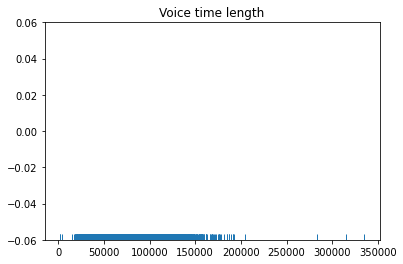

In [17]:
# 데이터 길이 분포 확인
print('total training set:', train_x.shape)
print('train_min:', train_mini)
data_len_list = []
for i in train_x:
    data_len_list.append(len(i))

sns.rugplot(data_len_list)
plt.title("Voice time length")
plt.show()

In [18]:
process_train = []
process_train_y = []
for i in range(len(train_x)):
    if len(train_x[i]) > 16000 and len(train_x[i]) < 200000:
        process_train.append(train_x[i])
        process_train_y.append(train_label["age_"][i])
        
train_x = np.array(process_train)
train_y = np.array(process_train_y)

In [19]:
train_x.shape, test_x.shape, train_y.shape

((25273,), (1990,), (25273,))

In [20]:
# 음성의 길이 중 가장 작은 길이를 구합니다.
train_mini = get_mini(train_x)
test_mini = get_mini(test_x)

total training set: (25273,)
train_min: 17280


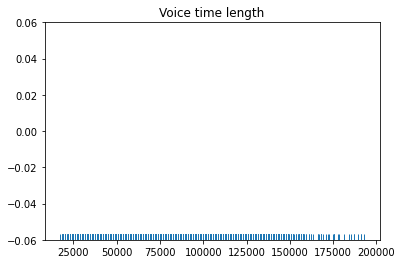

In [21]:
# 데이터 길이 분포 확인
print('total training set:', train_x.shape)
print('train_min:', train_mini)
data_len_list = []
for i in train_x:
    data_len_list.append(len(i))

sns.rugplot(data_len_list)
plt.title("Voice time length")
plt.show()

In [22]:
mini = np.min([train_mini, test_mini])

train_x = set_length(train_x, mini)
test_x = set_length(test_x, mini)

In [23]:
train_x

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -2.3750310e-04, -2.7187628e-04, -4.2706315e-04],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -1.3086757e-04, -1.4231540e-04, -1.2343311e-04],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -4.9192440e-03,  8.3049182e-03,  5.2764989e-03],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -6.0129777e-04,  5.0597754e-04,  1.7142133e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         3.0792236e-01,  3.8867188e-01,  3.9355469e-01]], dtype=float32)

In [24]:
# train_m = get_feature_mm(data = train_x)
# test_m = get_feature_mm(data = test_x)

# train_m = train_m.reshape(-1, train_m.shape[1], train_m.shape[2], 1)
# test_m = test_m.reshape(-1, test_m.shape[1], test_m.shape[2], 1)

In [25]:
# librosa를 이용해 feature를 추출합니다.
train_s = gen_4_mels(data=train_x)
test_s = gen_4_mels(data=test_x)

train_s = train_s.reshape(-1, train_s.shape[1], train_s.shape[2], 1)
test_s = test_s.reshape(-1, test_s.shape[1], test_s.shape[2], 1)

100%|██████████| 1990/1990 [00:04<00:00, 444.25it/s]


In [26]:
# np.save('./train_m.npy',arr=train_m)
# np.save('./test_m.npy',arr=test_m)

np.save('./train_s.npy',arr=train_s)
np.save('./test_s.npy',arr=test_s)

In [27]:
train_y.shape, train_s.shape, test_s.shape

((25273,), (25273, 64, 97, 1), (1990, 64, 97, 1))

In [28]:
# from tensorflow.keras.utils import to_categorical
# train_y = to_categorical(train_y)
# # y_val = to_categorical(y_val)

In [29]:
# del train_m
# del test_m
del train_s
del test_s

In [30]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.ReductionToOneDevice())
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [31]:
def block(input_, units = 32, dropout_rate = 0.5):
    
    x = Convolution2D(units, 3, padding ="same", activation = "relu")(input_)
    x = BatchNormalization()(x)
    x_res = x
    x = Convolution2D(units, 3, padding ="same", activation = "relu")(x)
    x = BatchNormalization()(x)
    x = Convolution2D(units, 3, padding ="same", activation = "relu")(x)
    x = BatchNormalization()(x)
    x = Add()([x, x_res])
    x = AveragePooling2D()(x)
    x = Dropout(rate=dropout_rate)(x)
    
    return x

def second_block(input_, units = 64, dropout_rate = 0.5):
    
    x = Convolution2D(units, 1, padding ="same", activation = "relu")(input_)
    x = Convolution2D(units, 3, padding ="same", activation = "relu")(x)
    x = Convolution2D(units * 4, 1, padding ="same", activation = "relu")(x)
    x = BatchNormalization()(x)
    x_res = x
    x = Convolution2D(units, 1, padding ="same", activation = "relu")(x)
    x = Convolution2D(units, 3, padding ="same", activation = "relu")(x)
    x = Convolution2D(units * 4, 1, padding ="same", activation = "relu")(x)
    x = BatchNormalization()(x)
    x = Convolution2D(units, 1, padding = "same", activation = "relu")(x)
    x = Convolution2D(units, 3, padding ="same", activation = "relu")(x)
    x = Convolution2D(units * 4, 1, padding = "same", activation = "relu")(x)
    x = BatchNormalization()(x)
    x = Add()([x, x_res])
    x = AveragePooling2D()(x)
    x = Dropout(rate=dropout_rate)(x)
    
    return x

def build_fn():
    dropout_rate = 0.3
    
    in_ = Input(shape = (train_x.shape[1:]))
    
    block_01 = block(in_, units = 32, dropout_rate = dropout_rate)
    block_02 = block(block_01, units = 64, dropout_rate = dropout_rate)
    block_03 = block(block_02, units = 128, dropout_rate = dropout_rate)

    block_04 = second_block(block_03, units = 64, dropout_rate = dropout_rate)
    block_05 = second_block(block_04, units = 128, dropout_rate = dropout_rate)

    x = Flatten()(block_05)

    x = Dense(units = 128, activation = "relu")(x)
    x = BatchNormalization()(x)
    x_res = x
    x = Dropout(rate = dropout_rate)(x)

    x = Dense(units = 128, activation = "relu")(x)
    x = BatchNormalization()(x)
    x = Add()([x_res, x])
    x = Dropout(rate = dropout_rate)(x)

    model_out = Dense(units = 8, activation = 'softmax')(x)
    model = Model(in_, model_out)
    
    return model

In [32]:
train_x= np.load('./train_s.npy')

In [33]:
split = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

# pred = []
# pred_ = []

fold_no = 1
for e , (train_idx, val_idx) in enumerate(split.split(train_x, train_y)):
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    
    checkpoint = ModelCheckpoint('./s_model'+f'/check{e}.h5',save_best_only=True)
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
    
    x_train, y_train = train_x[train_idx], train_y[train_idx]
    x_val, y_val = train_x[val_idx], train_y[val_idx]

    with strategy.scope():
        model = build_fn()
        model.compile(optimizer = keras.optimizers.Adam(0.0005),
                     loss = keras.losses.SparseCategoricalCrossentropy(),
                     metrics=['accuracy'])

    history = model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val), 
                        callbacks=[early_stopping_callback, checkpoint], epochs = 30)
    

    
    print("*******************************************************************")
    
    fold_no += 1

------------------------------------------------------------------------
Training for fold 1 ...
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/devic

711/711 [==============================] - 25s 36ms/step - loss: 1.6266 - accuracy: 0.2373 - val_loss: 1.6193 - val_accuracy: 0.2513
Epoch 6/30
711/711 [==============================] - 25s 35ms/step - loss: 1.6181 - accuracy: 0.2418 - val_loss: 1.6155 - val_accuracy: 0.2335
Epoch 7/30
711/711 [==============================] - 25s 35ms/step - loss: 1.6174 - accuracy: 0.2436 - val_loss: 1.6117 - val_accuracy: 0.2418
Epoch 8/30
711/711 [==============================] - 25s 35ms/step - loss: 1.6162 - accuracy: 0.2433 - val_loss: 1.6120 - val_accuracy: 0.2434
Epoch 9/30
711/711 [==============================] - 25s 35ms/step - loss: 1.6165 - accuracy: 0.2429 - val_loss: 1.6408 - val_accuracy: 0.2493
Epoch 10/30
711/711 [==============================] - 25s 35ms/step - loss: 1.6169 - accuracy: 0.2421 - val_loss: 1.6099 - val_accuracy: 0.2505
Epoch 11/30
711/711 [==============================] - 25s 35ms/step - loss: 1.6141 - accuracy: 0.2438 - val_loss: 1.6167 - val_accuracy: 0.2430
E

Epoch 1/30
711/711 [==============================] - 38s 39ms/step - loss: 2.2827 - accuracy: 0.1909 - val_loss: 1.6642 - val_accuracy: 0.2430
Epoch 2/30
711/711 [==============================] - 25s 35ms/step - loss: 1.7851 - accuracy: 0.2144 - val_loss: 1.6285 - val_accuracy: 0.2335
Epoch 3/30
711/711 [==============================] - 25s 35ms/step - loss: 1.6803 - accuracy: 0.2229 - val_loss: 1.6180 - val_accuracy: 0.2426
Epoch 4/30
711/711 [==============================] - 25s 35ms/step - loss: 1.6427 - accuracy: 0.2320 - val_loss: 1.6117 - val_accuracy: 0.2394
Epoch 5/30
711/711 [==============================] - 25s 35ms/step - loss: 1.6286 - accuracy: 0.2385 - val_loss: 1.7720 - val_accuracy: 0.2327
Epoch 6/30
711/711 [==============================] - 25s 35ms/step - loss: 1.6201 - accuracy: 0.2422 - val_loss: 1.6111 - val_accuracy: 0.2525
Epoch 7/30
711/711 [==============================] - 25s 35ms/step - loss: 1.6188 - accuracy: 0.2471 - val_loss: 1.6139 - val_accuracy:

In [34]:
# train_x= np.load('./train_m.npy')

In [35]:
# split = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 10)

# # pred = []
# # pred_ = []

# fold_no = 1
# for e , (train_idx, val_idx) in enumerate(split.split(train_x, train_y)):
    
#     print('------------------------------------------------------------------------')
#     print(f'Training for fold {fold_no} ...')
    
    
#     checkpoint = ModelCheckpoint('./m_model'+f'/check{e}.h5',save_best_only=True)
#     early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)
    
#     x_train, y_train = train_x[train_idx], train_y[train_idx]
#     x_val, y_val = train_x[val_idx], train_y[val_idx]

#     with strategy.scope():
#         model = build_fn()
#         model.compile(optimizer = keras.optimizers.Adam(0.0001),
#                      loss = keras.losses.SparseCategoricalCrossentropy(),
#                      metrics=['accuracy'])

#     history = model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val), 
#                         callbacks=[early_stopping_callback, checkpoint], epochs = 30)
    

    
#     print("*******************************************************************")
    
#     fold_no += 1

In [36]:
test_x= np.load('./test_s.npy')

In [37]:
pred1 = []
pred1_ = []

for e in range(10):
    model = build_fn()
    model.load_weights('./s_model'+f'/check{e}.h5')
    print("*******************************************************************")
    pred1.append(model.predict(test_x))
    pred1_.append(np.argmax(model.predict(test_x), axis = 1))
    print("*******************************************************************")
    print(e)

*******************************************************************
*******************************************************************
0
*******************************************************************
*******************************************************************
1
*******************************************************************
*******************************************************************
2
*******************************************************************
*******************************************************************
3
*******************************************************************
*******************************************************************
4
*******************************************************************
*******************************************************************
5
*******************************************************************
*******************************************************************
6
**********************************

In [38]:
# test_x= np.load('./test_m.npy')

In [39]:
# pred2 = []
# pred2_ = []

# for e in range(10):
#     model = build_fn()
#     model.load_weights('./m_model'+f'/check{e}.h5')
#     print("*******************************************************************")
#     pred2.append(model.predict(test_x))
#     pred2_.append(np.argmax(model.predict(test_x), axis = 1))
#     print("*******************************************************************")
#     print(e)

In [40]:
pred_1 = np.argmax(np.sum(pred1, axis =0), axis = 1)
# pred_2 = np.argmax(np.sum(pred2, axis =0), axis = 1)

In [41]:
sample_submission = pd.read_csv("open/sample_submission.csv")
sample_submission["age_"] = pred_1

In [45]:
sample_submission.to_csv("./baseline_10_9.csv", index = False)